# Example: Quantum Cavity Method (Belief Propagation)

This notebook demonstrates how to use the cavity method (belief propagation) using the simplest quantum cavity equations (check references in README file)

## Overview

The cavity method iteratively updates cavity messages until convergence. It can detect:
- Converged solutions (paramagnetic phase)
- Replica Symmetry Breaking (RSB) - when the solution becomes unstable

NOTE: with these equations, it is not possible to use susceptibility propagation (or, at least, the susceptibility matrix obtained is not symmetric). The reason being that these equations are NOT equivalent to the minimization of a free energy.


In [ ]:
import sys
from pathlib import Path

# Ensure repository root (parent of src) is on sys.path
REPO_ROOT = Path.cwd()
if not (REPO_ROOT / "src").exists():
    REPO_ROOT = REPO_ROOT.parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))


import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from src.graph_utils import generate_random_regular_graph, initialize_couplings
from src.cavity_method import belief_propagation, F_func
from src.analysis_utils import mean_excess_function, invert_function


## Setup: Generate Graph and Couplings


In [2]:
# Parameters
N = 1000          # Number of spins
degree = 3        # Graph degree
K_val = degree - 1
std_J = 1 / np.sqrt(K_val)  # Standard deviation for Gaussian couplings

# Build graph and couplings
G = generate_random_regular_graph(N, degree, seed=902)
J = initialize_couplings(G, std=std_J, seed=229)

print(f"Graph: {N} nodes, degree {degree}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Coupling std: {std_J:.4f}")


Graph: 1000 nodes, degree 3
Number of edges: 1500
Coupling std: 0.7071


## Run Belief Propagation


In [3]:
# Physical parameters
T = 0.25
beta = 1 / T
transverse_field = 0.64

# Run belief propagation
h_conv, b_conv, flag, max_it = belief_propagation(
    G, J, F_func, beta, transverse_field,
    max_iter=1000, tol=1e-5, init_std=0.01
)

print(f"\nConvergence status:")
print(f"  RSB detected: {flag}")
print(f"  Iterations: {max_it}")


100
0.07471876383062542
200
0.0013403044753019233
300
3.1351126861450807e-05

Convergence status:
  RSB detected: False
  Iterations: 336


## Analyze Results


h messages: mean=-0.0094, std=0.1351
b messages: mean=0.1733, std=0.0880
Max |h|: 0.6243
Max |b|: 0.4216


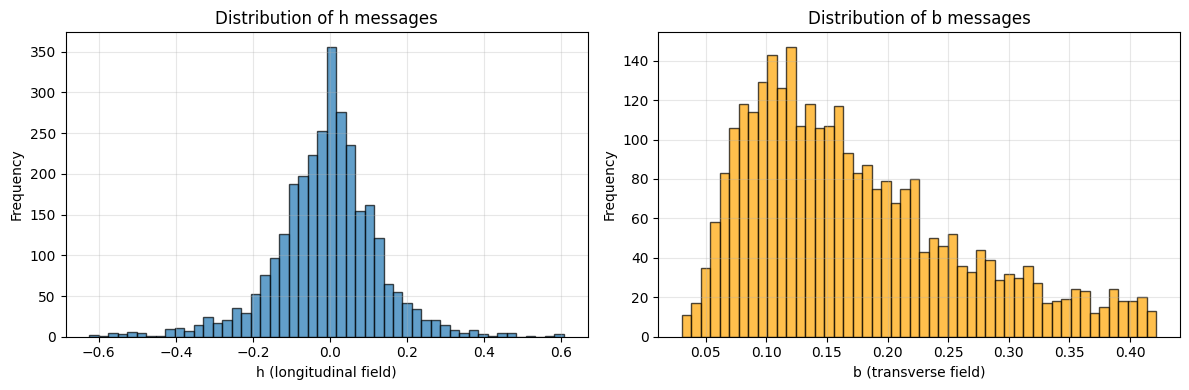

In [4]:
# Extract message arrays
sorted_edges = sorted(h_conv)
h_array = np.array([h_conv[edge] for edge in sorted_edges])
b_array = np.array([b_conv[edge] for edge in sorted_edges])

print(f"h messages: mean={np.mean(h_array):.4f}, std={np.std(h_array):.4f}")
print(f"b messages: mean={np.mean(b_array):.4f}, std={np.std(b_array):.4f}")
print(f"Max |h|: {np.max(np.abs(h_array)):.4f}")
print(f"Max |b|: {np.max(np.abs(b_array)):.4f}")

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(h_array, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('h (longitudinal field)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of h messages')
axes[0].grid(True, alpha=0.3)

axes[1].hist(b_array, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_xlabel('b (transverse field)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of b messages')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Tail Analysis of Messages

Log-binned histograms and mean-excess-function (MEF) to study distribution tails.


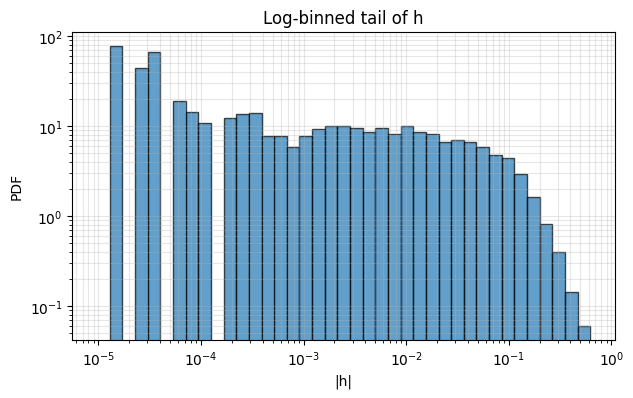

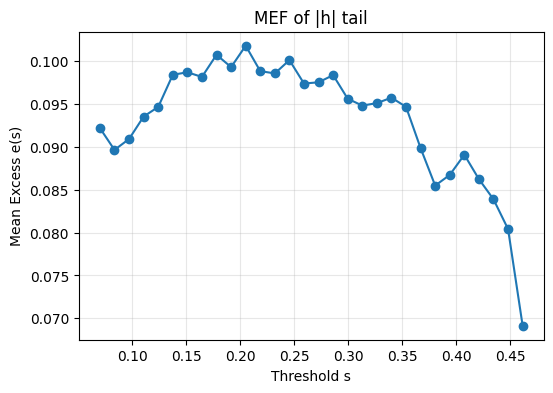

In [5]:
# Log-binned histogram for |h|
abs_h = np.abs(h_array)
logbins = np.logspace(np.log10(abs_h.min() + 1e-8), np.log10(abs_h.max()), 40)
plt.figure(figsize=(7, 4))
plt.hist(abs_h, bins=logbins, density=True, alpha=0.7, edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('|h|')
plt.ylabel('PDF')
plt.title('Log-binned tail of h')
plt.grid(True, which='both', alpha=0.3)
plt.show()

# Mean Excess Function on |h|
s_values = np.linspace(np.percentile(abs_h, 50), np.percentile(abs_h, 99), 30)
valid_s, e_s = mean_excess_function(abs_h, s_values, min_exceedances=20)
plt.figure(figsize=(6, 4))
plt.plot(valid_s, e_s, 'o-')
plt.xlabel('Threshold s')
plt.ylabel('Mean Excess e(s)')
plt.title('MEF of |h| tail')
plt.grid(True, alpha=0.3)
plt.show()
